<a href="https://colab.research.google.com/github/sunghyouk/study_room/blob/master/self_ML_DL_study_text/ch9_2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 순환 신경망으로 IMDB 리뷰 분류하기
IMDB: 인터넷 영화 데이터베이스에서 수집한 리뷰를 감상평에 따라 긍/부정으로 분류해 놓은 데이터셋  
총 50,000개의 데이터 중 각 25,000개씩 훈련/테스트 데이터가 있음  
텐서플로우 패키지 상 이미 토큰으로 만들어 놓은 데이터가 있음  
가장 많이 사용된 500 단어를 데이터로 사용

In [ ]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [ ]:
# 첫번째 데이터 혹은 토큰의 길이는?
print(len(train_input[0]))

218


In [ ]:
# 첫번째 데이터의 내용은?
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [ ]:
# validation set 만들기
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [ ]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [ ]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


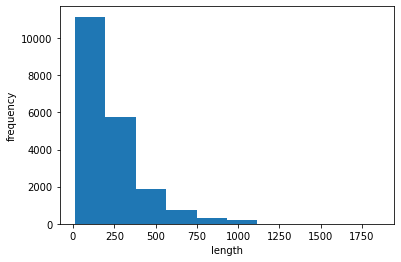

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

* 대부분의 리뷰 길이가 짧아서 앞에서 100 단어 정도만 사용해도 되겠다.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)

In [ ]:
print(train_seq.shape)

(20000, 100)


In [ ]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [ ]:
val_seq = pad_sequences(val_input, maxlen=100)

### 순환 신경망 만들기

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
# 원핫인코딩으로 바꾸기: 각 정수의 상대적인 크기 정보 없애기
train_oh = keras.utils.to_categorical(train_seq)

In [ ]:
print(train_oh.shape)

(20000, 100, 500)


In [ ]:
val_oh = keras.utils.to_categorical(val_seq)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


### 순환 신경망 훈련하기

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

In [ ]:
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 51ms/step - loss: 0.6964 - accuracy: 0.5056 - val_loss: 0.6943 - val_accuracy: 0.5232
Epoch 2/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6906 - accuracy: 0.5282 - val_loss: 0.6888 - val_accuracy: 0.5434
Epoch 3/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6832 - accuracy: 0.5586 - val_loss: 0.6799 - val_accuracy: 0.5772
Epoch 4/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6622 - accuracy: 0.6205 - val_loss: 0.6492 - val_accuracy: 0.6538
Epoch 5/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6375 - accuracy: 0.6675 - val_loss: 0.6320 - val_accuracy: 0.6752
Epoch 6/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6207 - accuracy: 0.6870 - val_loss: 0.6191 - val_accuracy: 0.6886
Epoch 7/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6073 - accuracy: 0.6996 - val_loss: 0.6087 - val_ac

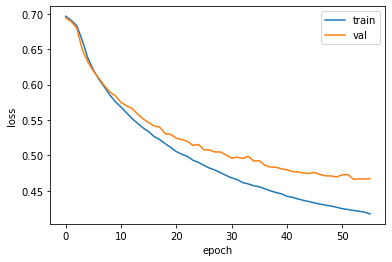

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### 단어 임베딩을 사용하기
각 단어를 고정된 크기의 실수 벡터로 변경  
장점: 입력으로 정수데이터를 받는다 (원핫인코딩으로 변경하지 않아도 가능)  
크기도 더 작다.

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model training
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 25ms/step - loss: 0.6836 - accuracy: 0.5620 - val_loss: 0.6658 - val_accuracy: 0.6240
Epoch 2/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6499 - accuracy: 0.6595 - val_loss: 0.6369 - val_accuracy: 0.6832
Epoch 3/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6218 - accuracy: 0.7088 - val_loss: 0.6201 - val_accuracy: 0.7004
Epoch 4/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6004 - accuracy: 0.7323 - val_loss: 0.5977 - val_accuracy: 0.7350
Epoch 5/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5813 - accuracy: 0.7482 - val_loss: 0.5846 - val_accuracy: 0.7308
Epoch 6/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5640 - accuracy: 0.7583 - val_loss: 0.5617 - val_accuracy: 0.7536
Epoch 7/100
313/313 [==============================] - 8s 24ms/step - loss: 0.5462 - accuracy: 0.7668 - val_loss: 0.5473 - val_accuracy:

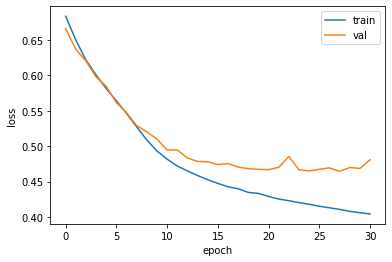

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()